## This notebook demonstrate how to model the 10 lucky dwarf galaxies in HSC images using [`the tractor`](https://github.com/dstndstn/tractor). 
- `tractor` asks for flux, shape, and morphology type (exponential or Sersic) to initialize a model. In this notebook, the flux and shape are taken from the HSC CModel catalog. The morphology type is also derived from HSC CModel catalog, based on `extendness`, `flux`, `ba`, `fracdev`, etc.

- Need help when installing `the tractor`? Check [this website](https://astrojacobli.github.io/blog/2018/10/Macbook-for-Astronomy#install-the-tractor).
- You need to install [`kuaizi`](https://github.com/AstroJacobLi/kuaizi) to run this notebook. `kuaizi` contains some handy tools I often use.

In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Load catalog and images
obj_cat = Table.read('/Users/jiaxuanli/Research/Merian/cosmos_test_1/cosmos_test_1-2021-02-04.fits')

In [4]:
obj_cat['name']

s18a_wide_226984_y
s18a_wide_233677_y
s18a_wide_238189_y
s18a_wide_240617_y
s18a_wide_255782_y
s18a_wide_265172_y
s18a_wide_274464_y
s18a_wide_275931_y
s18a_wide_277061_y
s18a_wide_301016_y


In [5]:
import scarlet # I only use this package to generate RGB image for display purpose.
## Initialize `unagi`
from unagi import hsc, config
from unagi import plotting
from unagi import task, catalog

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/jiaxuanli/Research/Packages/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


## Let's fit a dwarf step by step

In [56]:
channels = 'grizy'

obj = obj_cat[7]
obj_id = obj['name'].lstrip('s18a_wide').rstrip('_y')

cutout = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
    ) for filt in channels
]
psf_list = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
    ) for filt in channels
]

coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')
s_ang = obj['radius'] * u.arcsec

In [57]:
# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
# `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy

(-0.5, 178.5, -0.5, 178.5)

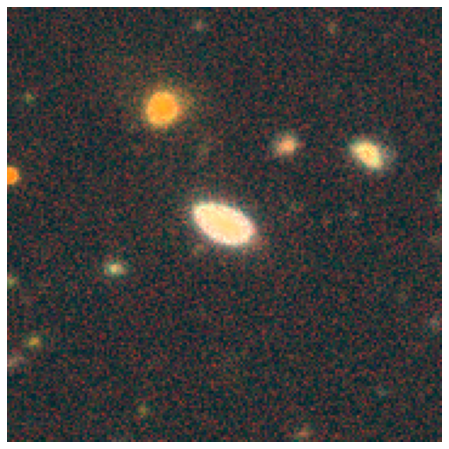

In [58]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img_rgb, origin='lower')
plt.axis('off')

In [59]:
## Use HSC CModel catalog to deblend and initialize `tractor`
from kuaizi.tractor.utils import makeCatalog

filt = 'z'
layer_ind = channels.index(filt)

In [60]:
# Retrieve HSC CModel catalog
cutout_objs = task.hsc_box_search(
    coord, box_size=s_ang * 1.1, archive=pdr2,
    verbose=True, psf=True, cmodel=True, aper=True, shape=True,
    meas=filt, flux=False, aper_type='3_20')

# Select "clean" images
cutout_clean, clean_mask = catalog.select_clean_objects(
    cutout_objs, return_catalog=True, verbose=True)

# Convert `RA, Dec` to `x, y`
x, y = data.wcs.wcs_world2pix(cutout_clean['ra'], cutout_clean['dec'], 0)
cutout_clean['x'] = x
cutout_clean['y'] = y

# sort by magnitude
cutout_clean.sort('cmodel_mag')

# Remove weird objects: abs(psf_mag - cmodel_mag) > 1
cutout_clean = cutout_clean[(cutout_clean['psf_mag'] - cutout_clean['cmodel_mag']) < 2.5]
# Remove faint objects satisfying `i_cmodel_mag > 26` or `i_psf_mag > 26`
cutout_clean = cutout_clean[(cutout_clean['i_cmodel_mag'] <= 26) & (cutout_clean['i_psf_mag'] <= 26)]

 [Done]
# 35/37 objects are clean.


# 23/23 objects are clean.
# There are 4 point sources on the cutout
# There are 19 extended sources on the cutout


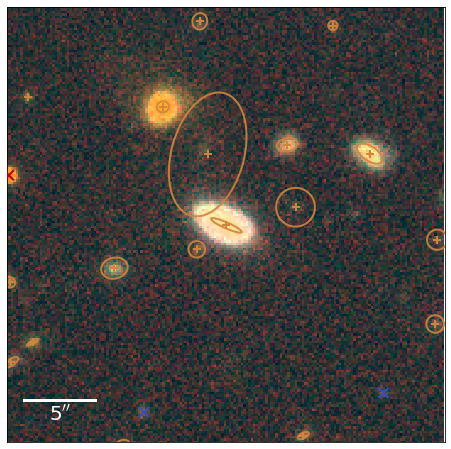

In [61]:
_ = plotting.cutout_show_objects(
    img_rgb, cutout_clean, cutout_wcs=data.wcs, xsize=8, show_weighted=True, band=filt) # Exp is brown. Dev is dashed-white.

In [62]:
catalog.moments_to_shape(
    cutout_clean,
    shape_type='cmodel_ellipse',
    axis_ratio=True,
    to_pixel=False,
    update=True);  # arcsec, degree

# Find out the target galaxy in CModel catalog
catalog_c = SkyCoord(cutout_clean['ra'], cutout_clean['dec'], unit='deg')
dist = coord.separation(catalog_c)
cen_obj_ind = np.argsort(dist)[0]
cen_obj = cutout_clean[cen_obj_ind]

## Assign types to each object in CModel catalog
obj_type = np.empty_like(cutout_clean['object_id'], dtype='S4')

star_mask = cutout_clean['{}_extendedness'.format(filt)] < 0.5
obj_type[star_mask] = 'PSF' # If extendedness is less than 0.5: assign 'PSF' type

fracdev = cutout_clean['cmodel_fracdev']
ba = cutout_clean['cmodel_ellipse_ba']
# If b/a > 0.8 (round shape): assign 'REX'
obj_type[(ba >= 0.8) & (~star_mask)] = 'REX'  # round_exp_galaxy
# If 0.6 < b/a < 0.8 (not very round) and `fracdev >= 0.6`: assign 'DEV'
obj_type[(ba < 0.8) & (fracdev >= 0.6) & (~star_mask)] = 'DEV' # dev_galaxy
# If 0.6 < b/a < 0.8 (not very round) and `fracdev < 0.6`: assign 'REX' (although it might not be very round)
obj_type[(ba < 0.8) & (ba > 0.6) & (fracdev < 0.6) & (~star_mask)] = 'REX' # round_exp_galaxy
# If b/a < 0.6 (elongated) and `fracdev < 0.6`: assign 'EXP'
obj_type[(ba <= 0.6) & (fracdev < 0.6) & (~star_mask)] = 'EXP' # exp_galaxy

# Target object is always Sersic
obj_type[cen_obj_ind] = 'SER'

cutout_clean['type'] = obj_type

In [63]:
from kuaizi.tractor.utils import tractor_iteration
from tractor import PixelizedPSF

 - Now you have 1 sources
 - Now you have 8 sources
   The chi-square is 5.039435e-05
 - Now you have 15 sources
 - Now you have 22 sources


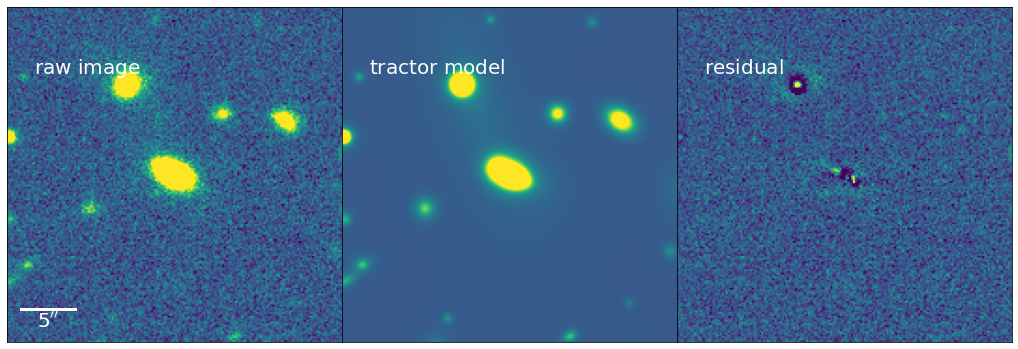

   The chi-square is 4.775176e-05


In [65]:
psf_obj = PixelizedPSF(data.psfs[layer_ind]) # Construct PSF

sources, trac_obj, fig = tractor_iteration(
    cutout_clean,
    data.wcs,
    data.images[layer_ind],
    data.weights[layer_ind],
    psf_obj,
    kuaizi.HSC_pixel_scale,
    shape_method='hsc',
    freeze_pos=False, # whether freeze positions of objects during fitting
    kfold=4, # how many rounds 
    first_num=cen_obj_ind + 1, # the number of objects for the first round
    fig_name='test')

Evaluating FFT mixture: 2 components in size 256 256
Amps: [ 1.3378762 -0.3378762]
Evaluating FFT mixture: 9 components in size 128 128
Amps: [0.00199772 0.01125156 0.03213934 0.07119277 0.13289826 0.20919977
 0.26822667 0.26286089 0.010233  ]
Evaluating FFT mixture: 9 components in size 64 64
Amps: [0.00199772 0.01125156 0.03213934 0.07119277 0.13289826 0.20919977
 0.26822667 0.26286089 0.010233  ]
Evaluating FFT mixture: 9 components in size 512 512
Amps: [0.00199772 0.01125156 0.03213934 0.07119277 0.13289826 0.20919977
 0.26822667 0.26286089 0.010233  ]
Evaluating FFT mixture: 6 components in size 128 128
Amps: [1.99485977e-04 2.61612679e-03 1.89726655e-02 1.00186544e-01
 3.68534484e-01 5.09490694e-01]
Evaluating FFT mixture: 6 components in size 128 128
Amps: [1.99485977e-04 2.61612679e-03 1.89726655e-02 1.00186544e-01
 3.68534484e-01 5.09490694e-01]
Evaluating FFT mixture: 6 components in size 128 128
Amps: [1.99485977e-04 2.61612679e-03 1.89726655e-02 1.00186544e-01
 3.68534484e

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

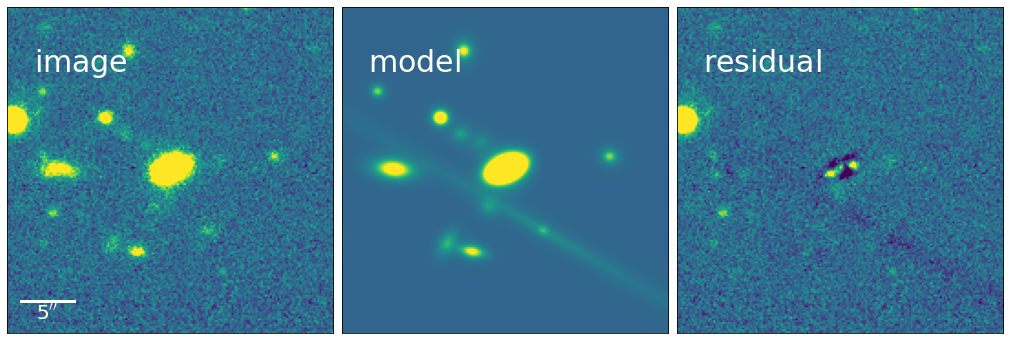

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

trac_mod = trac_obj.getModelImage(0, srcs=sources)

kuaizi.display.display_multiple(
    [data.images[layer_ind], trac_mod, data.images[layer_ind] - trac_mod],
    text=['image', 'model', 'residual'],
    ax=axes,
    scale_bar_y_offset=0.4)

## I've incorporate the above steps into `kuaizi.tractor.utils.tractor_cmodel` function.

In [ ]:
# obj2 z-band y-band error

In [31]:
from kuaizi.tractor.utils import tractor_hsc_cmodel

In [32]:
channels = 'grizy'

In [ ]:
# Save all the files to './cmodel'
import os
os.chdir('./cmodel/')

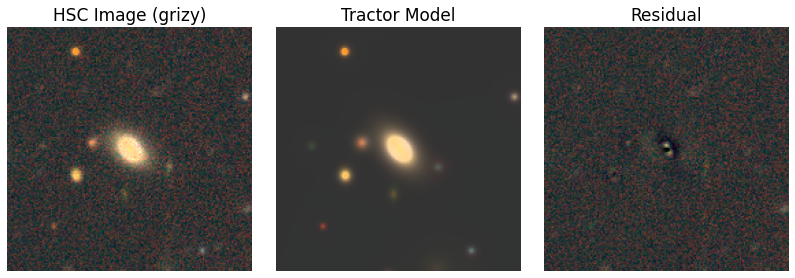

In [66]:
for obj in obj_cat[7:]:
    obj_name = obj['name'].rstrip('_y')
    obj_id = obj_name.lstrip('s18a_wide')
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')
    s_ang = obj['radius'] * u.arcsec
    
    cutout = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
        ) for filt in channels
    ]
    psf_list = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
        ) for filt in channels
    ]
    
    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    # `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy
    
    
    # Start fitting
    model_dict = {}
    for filt in channels:
        model_dict[filt] = tractor_hsc_cmodel(obj_name, coord, s_ang, filt, channels, data, pdr2, 
                                              use_cmodel_filt=None, freeze_pos=False, verbose=False)

    with open(obj_name + '_cmodel_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
    
    ### Make figures into a PDF file
    from fpdf import FPDF
    pdf = FPDF()
    pdf.add_page()
    for k, image in enumerate([obj_name + '_cmodel_tractor_' + filt + '.png' for filt in channels]):
        pdf.image(image, 21, 11 + k * 55, 167, 55)
    pdf.output(obj_name + "_cmodel_tractor.pdf", "F")

    # Visualize our model
    from kuaizi.tractor.utils import HiddenPrints
    with HiddenPrints():
        model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

    stretch = 1
    Q = 0.5
    channel_map = scarlet.display.channels_to_rgb(len(channels))

    img_rgb = scarlet.display.img_to_rgb(
        data.images,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    model_rgb = scarlet.display.img_to_rgb(
        model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    res_rgb = scarlet.display.img_to_rgb(
        data.images - model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)
    
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
    ax1.imshow(img_rgb, origin='lower')
    ax2.imshow(model_rgb, origin='lower')
    ax3.imshow(res_rgb, origin='lower')

    for ax in [ax1, ax2, ax3]:
        ax.axis('off')

    ax1.set_title('HSC Image (grizy)', fontsize=17)
    ax2.set_title('Tractor Model', fontsize=17)
    ax3.set_title('Residual', fontsize=17)

    plt.subplots_adjust(wspace=0.1)
    plt.savefig(obj_name + '_cmodel_tractor_rgb.png', 
                bbox_inches='tight', 
                metadata={'Comment': 'Each filter is fit seperately, using the HSC Cmodel catalog in each filter'})
    
    clear_output()
    #plt.close()